# Multivariate Time Series Prediction Using Transformers Architecture

The following Notebook shows the coding part of my Bachelor Thesis for the Information and Communication Systems and Services bachelor degree in the University of Applied Science Technikum Wien.

Author: Sergio Tallo Torres
Date: April 2022

# First: load imports needed for the project and project preparation

In [36]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

/content/Bsc_Thesis


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from sklearn.decomposition import PCA

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla P100-PCIE-16GB


In [38]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.11.0+cu113
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [39]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the value of the previous elemnt in the sequence).

In [40]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [41]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [42]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [43]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [44]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [45]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [46]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very different. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [47]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [48]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 789.97it/s]


In [49]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1042.64it/s]


In [50]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 959.75it/s]


In [51]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [52]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [53]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


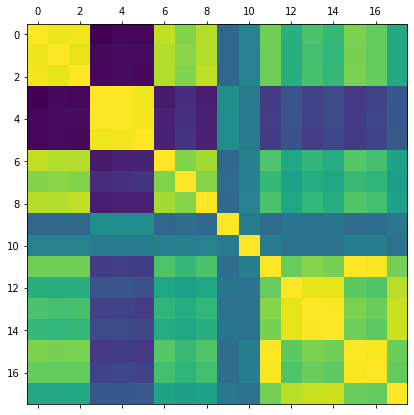

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810274, 0.16335739298653476, 0.07511546472382995, 0.054921627068028424, 0.05390616867076577, 0.04952232661739343, 0.022486349463995598, 0.013932731902136385, 0.012792662672300325, 0.009829012007199104, 0.004024926426955747, 0.002893959610103366, 0.002163271201445878, 0.001741116222641519, 0.0006928432299862775, 0.00021826337426103455, 0.00023351820917083064, 0.0004035851322244031]


In [54]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [55]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = stats.pearsonr(dataset_norm[i], dataset_norm[j])[0]
    if i != j:
      correlations.append(abs(correlation))
      feature.append(abs(correlation))
      print(correlation)
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686162
Correlation between PLN1 and PLN3
0.9606664987977854
Correlation between PLN1 and ULL1
-0.7274016376341781
Correlation between PLN1 and ULL2
-0.6955282277514699
Correlation between PLN1 and ULL3
-0.7030835410050383
Correlation between PLN1 and COS_PHI1
0.8410401295195358
Correlation between PLN1 and COS_PHI2
0.6731338062873106
Correlation between PLN1 and COS_PHI3
0.8122370309192151
Correlation between PLN1 and FREQ
-0.1545159794969927
Correlation between PLN1 and RC_DC
0.04144790238090616
Correlation between PLN1 and RC_AC
0.6311099014117806
Correlation between PLN1 and RC_50Hz
0.3688113546135111
Correlation between PLN1 and RC_150Hz
0.5078743784519382
Correlation between PLN1 and RC_<100Hz
0.43093253308676593
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453893
Correlation between PLN1 and RC_>1kHz
0.5928797475823843
Correlation between PLN1 and RC_>10kHz
0.3161918341465538
Mean of PLN1 co

In [56]:
# Covariance matrix, eigenvalues and explained variance

covmatrix = dataset_norm.cov()
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

acc = 0

for i, eigen in enumerate(eigenvalues):
  acc += eigen/np.sum(eigenvalues)
  print(f'Explained_variance {i +1} principal component: {eigen/np.sum(eigenvalues)} (accumulated {round(acc, 4)})')

Explained_variance 1 principal component: 0.5317647804810274 (accumulated 0.5318)
Explained_variance 2 principal component: 0.16335739298653476 (accumulated 0.6951)
Explained_variance 3 principal component: 0.07511546472382995 (accumulated 0.7702)
Explained_variance 4 principal component: 0.054921627068028424 (accumulated 0.8252)
Explained_variance 5 principal component: 0.05390616867076577 (accumulated 0.8791)
Explained_variance 6 principal component: 0.04952232661739343 (accumulated 0.9286)
Explained_variance 7 principal component: 0.022486349463995598 (accumulated 0.9511)
Explained_variance 8 principal component: 0.013932731902136385 (accumulated 0.965)
Explained_variance 9 principal component: 0.012792662672300325 (accumulated 0.9778)
Explained_variance 10 principal component: 0.009829012007199104 (accumulated 0.9876)
Explained_variance 11 principal component: 0.004024926426955747 (accumulated 0.9917)
Explained_variance 12 principal component: 0.002893959610103366 (accumulated 0.99

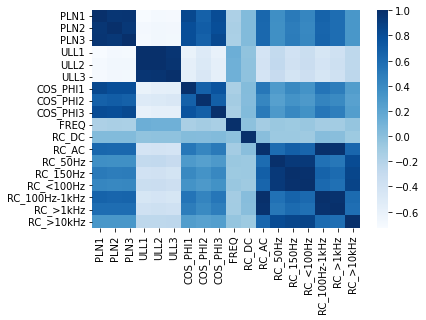

In [57]:
# Features correlations heat map

corr = dataset_norm.corr()
sns.heatmap(corr, cmap="Blues")

# Data loaders for the training

In [86]:
def create_sequece_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 31)):    
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    next = np.array(dataset_norm.iloc[i+30, 1:], dtype= float)
    target = np.array(dataset_norm.iloc[i+31, 1:], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [87]:
loader_train_seq, loader_test_seq = create_sequece_dataloaders_new(dataset_norm)

100%|██████████| 63329/63329 [00:57<00:00, 1098.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56996
length of test set (whole dataset): 6333




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [ ]:
def create_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

In [ ]:
loader_train, loader_test = create_dataloaders_new(dataset_norm)

100%|██████████| 63359/63359 [00:20<00:00, 3039.84it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [ ]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.4719053937120267
Standard deviation Loss of baselinemodel:  0.0954083966256769


Test set
Mean Loss of baselinemodel:  0.4824597011759596
Standard deviation Loss of baselinemodel:  0.09319914731521364




In [ ]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [ ]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN_whole = ANN_relu(18, 18).to(device)
print(model_FFN_whole)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN_whole.parameters(), lr=lr)


train_FFN = False

params_not_trained_whole = model_FFN_whole.parameters()

start_time = datetime.now()
if train_FFN is True:
  trained_model_FFN_whole , train_losses_whole, test_losses_whole = train(model_FFN_whole, criterion, optimizer_whole, loader_train, loader_test, n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'\nTraining time: {execution_time} seconds')

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Training time: 5.7e-05 seconds


In [ ]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_whole))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_whole], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [88]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)

        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        position_encoding = position_encoding.to(device)

        return position_encoding
        
    def forward (self, enc_input, dec_input):
        
        memory_mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=None, memory_mask=None)
        
        return output

In [89]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_1, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3167/3167 [01:37<00:00, 32.45it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 94.09it/s]



Current Mean loss Train Set:  0.4266093867290724

Test with test set


100%|██████████| 352/352 [00:03<00:00, 95.02it/s]



Current Mean loss Test Set:  0.4267500831152905


Epoch: 2 of 200
Training...


100%|██████████| 3167/3167 [01:36<00:00, 32.68it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 94.70it/s]



Current Mean loss Train Set:  0.400986947907346

Test with test set


100%|██████████| 352/352 [00:03<00:00, 93.40it/s]



Current Mean loss Test Set:  0.4011350210586732


Epoch: 3 of 200
Training...


100%|██████████| 3167/3167 [01:36<00:00, 32.92it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 94.68it/s]



Current Mean loss Train Set:  0.38080395300812925

Test with test set


100%|██████████| 352/352 [00:03<00:00, 94.53it/s]



Current Mean loss Test Set:  0.38118383135985245


Epoch: 4 of 200
Training...


100%|██████████| 3167/3167 [01:36<00:00, 32.94it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 95.72it/s]



Current Mean loss Train Set:  0.36930340332284045

Test with test set


100%|██████████| 352/352 [00:03<00:00, 95.77it/s]



Current Mean loss Test Set:  0.3697300889444622


Epoch: 5 of 200
Training...


100%|██████████| 3167/3167 [01:36<00:00, 32.97it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 95.08it/s]



Current Mean loss Train Set:  0.3616035796883056

Test with test set


100%|██████████| 352/352 [00:03<00:00, 95.31it/s]



Current Mean loss Test Set:  0.36258968575434253


Epoch: 6 of 200
Training...


100%|██████████| 3167/3167 [01:35<00:00, 33.15it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 96.48it/s]



Current Mean loss Train Set:  0.357407875328475

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.95it/s]



Current Mean loss Test Set:  0.35824408174746414


Epoch: 7 of 200
Training...


100%|██████████| 3167/3167 [01:34<00:00, 33.35it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 96.45it/s]



Current Mean loss Train Set:  0.35279601026605195

Test with test set


100%|██████████| 352/352 [00:03<00:00, 97.22it/s]



Current Mean loss Test Set:  0.35369517967443576


Epoch: 8 of 200
Training...


100%|██████████| 3167/3167 [01:34<00:00, 33.49it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 96.27it/s]



Current Mean loss Train Set:  0.3504669907004968

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.84it/s]



Current Mean loss Test Set:  0.35121367092836986


Epoch: 9 of 200
Training...


100%|██████████| 3167/3167 [01:36<00:00, 32.95it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 95.46it/s]



Current Mean loss Train Set:  0.3464972010199339

Test with test set


100%|██████████| 352/352 [00:03<00:00, 94.67it/s]



Current Mean loss Test Set:  0.34732077592475846


Epoch: 10 of 200
Training...


100%|██████████| 3167/3167 [01:35<00:00, 33.05it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 94.97it/s]



Current Mean loss Train Set:  0.3446560330267844

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.21it/s]



Current Mean loss Test Set:  0.3446944059211422


Epoch: 11 of 200
Training...


100%|██████████| 3167/3167 [01:35<00:00, 33.17it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 95.94it/s]



Current Mean loss Train Set:  0.34153775909852635

Test with test set


100%|██████████| 352/352 [00:03<00:00, 95.84it/s]



Current Mean loss Test Set:  0.34170531591569836


Epoch: 12 of 200
Training...


100%|██████████| 3167/3167 [01:35<00:00, 33.29it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.93it/s]



Current Mean loss Train Set:  0.33993628007081317

Test with test set


100%|██████████| 352/352 [00:03<00:00, 97.22it/s]



Current Mean loss Test Set:  0.3404665913178839


Epoch: 13 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.80it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.07it/s]



Current Mean loss Train Set:  0.33878212285448334

Test with test set


100%|██████████| 352/352 [00:03<00:00, 97.21it/s]



Current Mean loss Test Set:  0.33886186604980717


Epoch: 14 of 200
Training...


100%|██████████| 3167/3167 [01:34<00:00, 33.56it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.12it/s]



Current Mean loss Train Set:  0.3371556610631235

Test with test set


100%|██████████| 352/352 [00:03<00:00, 97.14it/s]



Current Mean loss Test Set:  0.3379527216523208


Epoch: 15 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.85it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.62it/s]



Current Mean loss Train Set:  0.3347652649085229

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.50it/s]



Current Mean loss Test Set:  0.33503439209677954


Epoch: 16 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 34.03it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 98.44it/s]



Current Mean loss Train Set:  0.33503471401011037

Test with test set


100%|██████████| 352/352 [00:03<00:00, 100.34it/s]



Current Mean loss Test Set:  0.3354536515067924


Epoch: 17 of 200
Training...


100%|██████████| 3167/3167 [01:32<00:00, 34.14it/s]



Test with training set


100%|██████████| 3167/3167 [00:31<00:00, 99.16it/s]



Current Mean loss Train Set:  0.33220234769242096

Test with test set


100%|██████████| 352/352 [00:03<00:00, 98.60it/s]



Current Mean loss Test Set:  0.33275912185622886


Epoch: 18 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.95it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 98.76it/s]



Current Mean loss Train Set:  0.3322121435614614

Test with test set


100%|██████████| 352/352 [00:03<00:00, 99.20it/s]



Current Mean loss Test Set:  0.3321016391485252


Epoch: 19 of 200
Training...


100%|██████████| 3167/3167 [01:32<00:00, 34.18it/s]



Test with training set


100%|██████████| 3167/3167 [00:31<00:00, 99.44it/s]



Current Mean loss Train Set:  0.33101058534673233

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.81it/s]



Current Mean loss Test Set:  0.331429818560454


Epoch: 20 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.72it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.05it/s]



Current Mean loss Train Set:  0.3294935017579506

Test with test set


100%|██████████| 352/352 [00:03<00:00, 95.43it/s]



Current Mean loss Test Set:  0.3299206712029197


Epoch: 21 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.70it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.21it/s]



Current Mean loss Train Set:  0.33042063740269406

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.70it/s]



Current Mean loss Test Set:  0.3305330681614578


Epoch: 22 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.78it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.12it/s]



Current Mean loss Train Set:  0.3270379839859665

Test with test set


100%|██████████| 352/352 [00:03<00:00, 97.84it/s]



Current Mean loss Test Set:  0.327145588922907


Epoch: 23 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.71it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.21it/s]



Current Mean loss Train Set:  0.32671705803492485

Test with test set


100%|██████████| 352/352 [00:03<00:00, 97.05it/s]



Current Mean loss Test Set:  0.3269465745596046


Epoch: 24 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.70it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 96.78it/s]



Current Mean loss Train Set:  0.32599293171211413

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.98it/s]



Current Mean loss Test Set:  0.3260943831198595


Epoch: 25 of 200
Training...


100%|██████████| 3167/3167 [01:35<00:00, 33.10it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 96.09it/s]



Current Mean loss Train Set:  0.32525819954075647

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.68it/s]



Current Mean loss Test Set:  0.3255610065534711


Epoch: 26 of 200
Training...


100%|██████████| 3167/3167 [01:34<00:00, 33.38it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 96.69it/s]



Current Mean loss Train Set:  0.3273695093630465

Test with test set


100%|██████████| 352/352 [00:03<00:00, 95.86it/s]



Current Mean loss Test Set:  0.3273742090148682


Epoch: 27 of 200
Training...


100%|██████████| 3167/3167 [01:35<00:00, 33.25it/s]



Test with training set


100%|██████████| 3167/3167 [00:33<00:00, 94.96it/s]



Current Mean loss Train Set:  0.3231662549843049

Test with test set


100%|██████████| 352/352 [00:03<00:00, 95.79it/s]



Current Mean loss Test Set:  0.3232478680173782


Epoch: 28 of 200
Training...


100%|██████████| 3167/3167 [01:34<00:00, 33.51it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 97.66it/s]



Current Mean loss Train Set:  0.3220618528604771

Test with test set


100%|██████████| 352/352 [00:03<00:00, 98.99it/s] 



Current Mean loss Test Set:  0.32247600450434466


Epoch: 29 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 33.98it/s]



Test with training set


100%|██████████| 3167/3167 [00:31<00:00, 99.15it/s]



Current Mean loss Train Set:  0.3203336052763601

Test with test set


100%|██████████| 352/352 [00:03<00:00, 97.78it/s]



Current Mean loss Test Set:  0.32071478868072684


Epoch: 30 of 200
Training...


100%|██████████| 3167/3167 [01:33<00:00, 34.04it/s]



Test with training set


100%|██████████| 3167/3167 [00:32<00:00, 98.13it/s]



Current Mean loss Train Set:  0.3189157485670196

Test with test set


100%|██████████| 352/352 [00:03<00:00, 96.23it/s]



Current Mean loss Test Set:  0.3194622080773115


Epoch: 31 of 200
Training...


 62%|██████▏   | 1960/3167 [00:58<00:36, 33.16it/s]

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train Loss Baseline model')

  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_2, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.64it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 140.59it/s]



Current Mean loss Train Set:  0.368629965437086

Test with test set


100%|██████████| 106/106 [00:00<00:00, 141.00it/s]



Current Mean loss Test Set:  0.3744269738782127


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.49it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.60it/s]



Current Mean loss Train Set:  0.33864967790089157

Test with test set


100%|██████████| 106/106 [00:00<00:00, 140.71it/s]



Current Mean loss Test Set:  0.3433273847935335


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.59it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.45it/s]



Current Mean loss Train Set:  0.3316226080060005

Test with test set


100%|██████████| 106/106 [00:00<00:00, 142.99it/s]



Current Mean loss Test Set:  0.3368941480821034


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.47it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 141.62it/s]



Current Mean loss Train Set:  0.3102460512205174

Test with test set


100%|██████████| 106/106 [00:00<00:00, 138.15it/s]



Current Mean loss Test Set:  0.31602696976009403


Epoch: 5 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.89it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.20it/s]



Current Mean loss Train Set:  0.3044847197909104

Test with test set


100%|██████████| 106/106 [00:00<00:00, 143.21it/s]



Current Mean loss Test Set:  0.31109967898085433


Epoch: 6 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.52it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 141.66it/s]



Current Mean loss Train Set:  0.287682728187034

Test with test set


100%|██████████| 106/106 [00:00<00:00, 145.81it/s]



Current Mean loss Test Set:  0.2932425054176798


Epoch: 7 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.37it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 142.49it/s]



Current Mean loss Train Set:  0.2775334142070068

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.09it/s]



Current Mean loss Test Set:  0.2837821361872385


Epoch: 8 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.57it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.77it/s]



Current Mean loss Train Set:  0.2749200972444133

Test with test set


100%|██████████| 106/106 [00:00<00:00, 141.78it/s]



Current Mean loss Test Set:  0.2820763623095908


Epoch: 9 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.24it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.64it/s]



Current Mean loss Train Set:  0.27288705405436064

Test with test set


100%|██████████| 106/106 [00:00<00:00, 138.38it/s]



Current Mean loss Test Set:  0.27918889949906545


Epoch: 10 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.51it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 141.32it/s]



Current Mean loss Train Set:  0.26648806953116466

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.71it/s]



Current Mean loss Test Set:  0.2736188994263703


Epoch: 11 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.43it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.62it/s]



Current Mean loss Train Set:  0.2659644996963049

Test with test set


100%|██████████| 106/106 [00:00<00:00, 139.08it/s]



Current Mean loss Test Set:  0.2735322484711431


Epoch: 12 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.37it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.45it/s]



Current Mean loss Train Set:  0.2604739746451378

Test with test set


100%|██████████| 106/106 [00:00<00:00, 135.63it/s]



Current Mean loss Test Set:  0.2677830561714352


Epoch: 13 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.40it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.89it/s]



Current Mean loss Train Set:  0.2643203566419451

Test with test set


100%|██████████| 106/106 [00:00<00:00, 141.63it/s]



Current Mean loss Test Set:  0.2718950389128811


Epoch: 14 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.75it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.48it/s]



Current Mean loss Train Set:  0.25838776585302853

Test with test set


100%|██████████| 106/106 [00:00<00:00, 142.86it/s]



Current Mean loss Test Set:  0.266511581275823


Epoch: 15 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.12it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.82it/s]



Current Mean loss Train Set:  0.26145331889390944

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.78it/s]



Current Mean loss Test Set:  0.26816929764342756


Epoch: 16 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.50it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 142.61it/s]



Current Mean loss Train Set:  0.26259062974076525

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.88it/s]



Current Mean loss Test Set:  0.2721832675753899


Epoch: 17 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.91it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.41it/s]



Current Mean loss Train Set:  0.2551961512314646

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.22it/s]



Current Mean loss Test Set:  0.262419693031401


Epoch: 18 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.53it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.32it/s]



Current Mean loss Train Set:  0.25313896532121455

Test with test set


100%|██████████| 106/106 [00:00<00:00, 141.12it/s]



Current Mean loss Test Set:  0.26053399648868814


Epoch: 19 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.43it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.84it/s]



Current Mean loss Train Set:  0.2542585754394531

Test with test set


100%|██████████| 106/106 [00:00<00:00, 146.49it/s]



Current Mean loss Test Set:  0.2617991350169452


Epoch: 20 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.38it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.61it/s]



Current Mean loss Train Set:  0.2606793349510745

Test with test set


100%|██████████| 106/106 [00:00<00:00, 137.95it/s]



Current Mean loss Test Set:  0.2671255037750838


Epoch: 21 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.63it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.79it/s]



Current Mean loss Train Set:  0.26118778765201567

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.72it/s]



Current Mean loss Test Set:  0.26815506900256536


Epoch: 22 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.89it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.96it/s]



Current Mean loss Train Set:  0.25170953891779246

Test with test set


100%|██████████| 106/106 [00:00<00:00, 140.76it/s]



Current Mean loss Test Set:  0.2585355079961273


Epoch: 23 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.65it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.61it/s]



Current Mean loss Train Set:  0.2512538628829153

Test with test set


100%|██████████| 106/106 [00:00<00:00, 137.94it/s]



Current Mean loss Test Set:  0.25782924243864025


Epoch: 24 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.26it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.28it/s]



Current Mean loss Train Set:  0.2532986963893238

Test with test set


100%|██████████| 106/106 [00:00<00:00, 143.87it/s]



Current Mean loss Test Set:  0.26107740880183455


Epoch: 25 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.96it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.15it/s]



Current Mean loss Train Set:  0.25512027274621163

Test with test set


100%|██████████| 106/106 [00:00<00:00, 136.88it/s]



Current Mean loss Test Set:  0.26484822706793837


Epoch: 26 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.65it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.87it/s]



Current Mean loss Train Set:  0.2508773920567412

Test with test set


100%|██████████| 106/106 [00:00<00:00, 132.70it/s]



Current Mean loss Test Set:  0.2597482896076058


Epoch: 27 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.97it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.10it/s]



Current Mean loss Train Set:  0.25204329314984775

Test with test set


100%|██████████| 106/106 [00:00<00:00, 140.87it/s]



Current Mean loss Test Set:  0.26026859499935834


Epoch: 28 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.12it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.46it/s]



Current Mean loss Train Set:  0.2516553879411597

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.57it/s]



Current Mean loss Test Set:  0.25894762491280177


Epoch: 29 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.67it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.05it/s]



Current Mean loss Train Set:  0.24813496134783092

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.93it/s]



Current Mean loss Test Set:  0.2566385274788119


Epoch: 30 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.77it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 140.40it/s]



Current Mean loss Train Set:  0.2535802989413864

Test with test set


100%|██████████| 106/106 [00:00<00:00, 131.47it/s]



Current Mean loss Test Set:  0.2624477557135078


Epoch: 31 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.31it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 137.74it/s]



Current Mean loss Train Set:  0.25777189800613803

Test with test set


100%|██████████| 106/106 [00:00<00:00, 134.89it/s]



Current Mean loss Test Set:  0.26527816296186085


Epoch: 32 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.41it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.18it/s]



Current Mean loss Train Set:  0.24650334497815685

Test with test set


100%|██████████| 106/106 [00:00<00:00, 137.17it/s]



Current Mean loss Test Set:  0.2557216520017048


Epoch: 33 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.57it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.40it/s]



Current Mean loss Train Set:  0.2513035785681323

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.65it/s]



Current Mean loss Test Set:  0.26060377469040313


Epoch: 34 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.76it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 142.99it/s]



Current Mean loss Train Set:  0.2479231665322655

Test with test set


100%|██████████| 106/106 [00:00<00:00, 145.88it/s]



Current Mean loss Test Set:  0.2573447756047519


Epoch: 35 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.16it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.97it/s]



Current Mean loss Train Set:  0.25018673863850144

Test with test set


100%|██████████| 106/106 [00:00<00:00, 146.75it/s]



Current Mean loss Test Set:  0.2594035928541759


Epoch: 36 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.24it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.19it/s]



Current Mean loss Train Set:  0.24753296420762413

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.56it/s]



Current Mean loss Test Set:  0.25624212468007823


Epoch: 37 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.09it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.01it/s]



Current Mean loss Train Set:  0.24668103757657503

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.22it/s]



Current Mean loss Test Set:  0.2569118487947392


Epoch: 38 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.91it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 148.06it/s]



Current Mean loss Train Set:  0.24823144028061314

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.00it/s]



Current Mean loss Test Set:  0.2568920012914909


Epoch: 39 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.12it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.18it/s]



Current Mean loss Train Set:  0.25901617787386244

Test with test set


100%|██████████| 106/106 [00:00<00:00, 150.17it/s]



Current Mean loss Test Set:  0.26854407168784233


Epoch: 40 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.08it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.38it/s]



Current Mean loss Train Set:  0.2503944799617717

Test with test set


100%|██████████| 106/106 [00:00<00:00, 145.79it/s]



Current Mean loss Test Set:  0.2602967764690237


Epoch: 41 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.08it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 147.07it/s]



Current Mean loss Train Set:  0.2529666016603771

Test with test set


100%|██████████| 106/106 [00:00<00:00, 150.61it/s]



Current Mean loss Test Set:  0.2652526435987005


Epoch: 42 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.57it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.06it/s]



Current Mean loss Train Set:  0.24443982356473018

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.21it/s]



Current Mean loss Test Set:  0.2536058216443602


Epoch: 43 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.07it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 149.45it/s]



Current Mean loss Train Set:  0.24347592957709965

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.63it/s]



Current Mean loss Test Set:  0.253887359123185


Epoch: 44 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.89it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.25it/s]



Current Mean loss Train Set:  0.25721167327542055

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.19it/s]



Current Mean loss Test Set:  0.2698330561507423


Epoch: 45 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.59it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.96it/s]



Current Mean loss Train Set:  0.2423801163780062

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.52it/s]



Current Mean loss Test Set:  0.25185745350032485


Epoch: 46 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.30it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 148.42it/s]



Current Mean loss Train Set:  0.24166693635677036

Test with test set


100%|██████████| 106/106 [00:00<00:00, 137.07it/s]



Current Mean loss Test Set:  0.25081673868984544


Epoch: 47 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.79it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 148.17it/s]



Current Mean loss Train Set:  0.2576309434677425

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.87it/s]



Current Mean loss Test Set:  0.26435224922760475


Epoch: 48 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.37it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 142.35it/s]



Current Mean loss Train Set:  0.2415138421717443

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.23it/s]



Current Mean loss Test Set:  0.25081601443718066


Epoch: 49 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.47it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.70it/s]



Current Mean loss Train Set:  0.24449309200048447

Test with test set


100%|██████████| 106/106 [00:00<00:00, 142.19it/s]



Current Mean loss Test Set:  0.2557052643793934


Epoch: 50 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.14it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 148.93it/s]



Current Mean loss Train Set:  0.24332507836191278

Test with test set


100%|██████████| 106/106 [00:00<00:00, 136.86it/s]



Current Mean loss Test Set:  0.25308507245104267


Epoch: 51 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.92it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 149.02it/s]



Current Mean loss Train Set:  0.24008277718958101

Test with test set


100%|██████████| 106/106 [00:00<00:00, 143.23it/s]



Current Mean loss Test Set:  0.2501282274441899


Epoch: 52 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.79it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.16it/s]



Current Mean loss Train Set:  0.2419558822481256

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.12it/s]



Current Mean loss Test Set:  0.25017928936571443


Epoch: 53 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.95it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.86it/s]



Current Mean loss Train Set:  0.24056653396079414

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.80it/s]



Current Mean loss Test Set:  0.24991223722133996


Epoch: 54 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.16it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.36it/s]



Current Mean loss Train Set:  0.23792702527422654

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.55it/s]



Current Mean loss Test Set:  0.24809383347911654


Epoch: 55 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.27it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.44it/s]



Current Mean loss Train Set:  0.24129627794027328

Test with test set


100%|██████████| 106/106 [00:00<00:00, 145.61it/s]



Current Mean loss Test Set:  0.2531601238363194


Epoch: 56 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.51it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 149.58it/s]



Current Mean loss Train Set:  0.2388410105517036

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.37it/s]



Current Mean loss Test Set:  0.24900058600700126


Epoch: 57 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.35it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.33it/s]



Current Mean loss Train Set:  0.23894166918177354

Test with test set


100%|██████████| 106/106 [00:00<00:00, 149.89it/s]



Current Mean loss Test Set:  0.24833126998734925


Epoch: 58 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.27it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.49it/s]



Current Mean loss Train Set:  0.2382353559293245

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.39it/s]



Current Mean loss Test Set:  0.24762164084416516


Epoch: 59 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.27it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.84it/s]



Current Mean loss Train Set:  0.2368118555765403

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.09it/s]



Current Mean loss Test Set:  0.24701073344023722


Epoch: 60 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.58it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.70it/s]



Current Mean loss Train Set:  0.23716977404920678

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.12it/s]



Current Mean loss Test Set:  0.24662698369543506


Epoch: 61 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.45it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.46it/s]



Current Mean loss Train Set:  0.23921387485767664

Test with test set


100%|██████████| 106/106 [00:00<00:00, 145.87it/s]



Current Mean loss Test Set:  0.24809640069615166


Epoch: 62 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.79it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.66it/s]



Current Mean loss Train Set:  0.23691183606260702

Test with test set


100%|██████████| 106/106 [00:00<00:00, 146.92it/s]



Current Mean loss Test Set:  0.2469422402528097


Epoch: 63 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.88it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.01it/s]



Current Mean loss Train Set:  0.23597486566556128

Test with test set


100%|██████████| 106/106 [00:00<00:00, 146.65it/s]



Current Mean loss Test Set:  0.24603018558250284


Epoch: 64 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.28it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.85it/s]



Current Mean loss Train Set:  0.2340665818201868

Test with test set


100%|██████████| 106/106 [00:00<00:00, 137.72it/s]



Current Mean loss Test Set:  0.24469517860210166


Epoch: 65 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.28it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 148.27it/s]



Current Mean loss Train Set:  0.23828368745352094

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.32it/s]



Current Mean loss Test Set:  0.24560327195333984


Epoch: 66 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 39.19it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.68it/s]



Current Mean loss Train Set:  0.23412952145463542

Test with test set


100%|██████████| 106/106 [00:00<00:00, 143.45it/s]



Current Mean loss Test Set:  0.24493739191653593


Epoch: 67 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.85it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.83it/s]



Current Mean loss Train Set:  0.23520687729120254

Test with test set


100%|██████████| 106/106 [00:00<00:00, 142.18it/s]



Current Mean loss Test Set:  0.24697750019577314


Epoch: 68 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.84it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 138.17it/s]



Current Mean loss Train Set:  0.23979696852596183

Test with test set


100%|██████████| 106/106 [00:00<00:00, 142.87it/s]



Current Mean loss Test Set:  0.2494543288957398


Epoch: 69 of 200
Training...


100%|██████████| 950/950 [00:25<00:00, 37.74it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.04it/s]



Current Mean loss Train Set:  0.23701798986447484

Test with test set


100%|██████████| 106/106 [00:00<00:00, 133.08it/s]



Current Mean loss Test Set:  0.24666248290043957


Epoch: 70 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.47it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.42it/s]



Current Mean loss Train Set:  0.23356196874066404

Test with test set


100%|██████████| 106/106 [00:00<00:00, 145.82it/s]



Current Mean loss Test Set:  0.24520123061144128


Epoch: 71 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.45it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 143.29it/s]



Current Mean loss Train Set:  0.233561045919594

Test with test set


100%|██████████| 106/106 [00:00<00:00, 141.99it/s]



Current Mean loss Test Set:  0.24399998587257457


Epoch: 72 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.87it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.77it/s]



Current Mean loss Train Set:  0.23763771849243265

Test with test set


100%|██████████| 106/106 [00:00<00:00, 148.21it/s]



Current Mean loss Test Set:  0.2460987427324619


Epoch: 73 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.37it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 142.84it/s]



Current Mean loss Train Set:  0.23680003034441094

Test with test set


100%|██████████| 106/106 [00:00<00:00, 142.40it/s]



Current Mean loss Test Set:  0.24681005444166795


Epoch: 74 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.39it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 142.99it/s]



Current Mean loss Train Set:  0.23362633678473924

Test with test set


100%|██████████| 106/106 [00:00<00:00, 135.87it/s]



Current Mean loss Test Set:  0.24436854247776968


Epoch: 75 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.35it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 146.17it/s]



Current Mean loss Train Set:  0.2376656352375683

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.57it/s]



Current Mean loss Test Set:  0.2493065667321097


Epoch: 76 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.12it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.23it/s]



Current Mean loss Train Set:  0.23342761711070412

Test with test set


100%|██████████| 106/106 [00:00<00:00, 143.91it/s]



Current Mean loss Test Set:  0.24318326278677527


Epoch: 77 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.84it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.64it/s]



Current Mean loss Train Set:  0.2352203768962308

Test with test set


100%|██████████| 106/106 [00:00<00:00, 143.14it/s]



Current Mean loss Test Set:  0.24468198081232467


Epoch: 78 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.36it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 141.28it/s]



Current Mean loss Train Set:  0.2369243597513751

Test with test set


100%|██████████| 106/106 [00:00<00:00, 142.92it/s]



Current Mean loss Test Set:  0.24638695944592637


Epoch: 79 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.50it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 141.23it/s]



Current Mean loss Train Set:  0.2318168431049899

Test with test set


100%|██████████| 106/106 [00:00<00:00, 133.67it/s]



Current Mean loss Test Set:  0.2432777667945286


Epoch: 80 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.42it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 141.31it/s]



Current Mean loss Train Set:  0.2344647650185384

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.19it/s]



Current Mean loss Test Set:  0.2435644027197136


Epoch: 81 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.65it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.52it/s]



Current Mean loss Train Set:  0.2357638956998524

Test with test set


100%|██████████| 106/106 [00:00<00:00, 143.83it/s]



Current Mean loss Test Set:  0.24411999968425283


Epoch: 82 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.69it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.53it/s]



Current Mean loss Train Set:  0.23350527742975635

Test with test set


100%|██████████| 106/106 [00:00<00:00, 146.31it/s]



Current Mean loss Test Set:  0.24556629064510455


Epoch: 83 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.22it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 139.99it/s]



Current Mean loss Train Set:  0.23349983725108597

Test with test set


100%|██████████| 106/106 [00:00<00:00, 144.12it/s]



Current Mean loss Test Set:  0.24434933403752884


Epoch: 84 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.39it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 145.34it/s]



Current Mean loss Train Set:  0.23059574975779182

Test with test set


100%|██████████| 106/106 [00:00<00:00, 147.17it/s]



Current Mean loss Test Set:  0.24127433575549215


Epoch: 85 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.85it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 142.84it/s]



Current Mean loss Train Set:  0.23446645121825369

Test with test set


100%|██████████| 106/106 [00:00<00:00, 137.20it/s]



Current Mean loss Test Set:  0.2457718108341379


Epoch: 86 of 200
Training...


100%|██████████| 950/950 [00:24<00:00, 38.63it/s]



Test with training set


100%|██████████| 950/950 [00:06<00:00, 144.51it/s]



Current Mean loss Train Set:  0.23065474445882597

Test with test set


100%|██████████| 106/106 [00:00<00:00, 139.80it/s]



Current Mean loss Test Set:  0.24072151265616687


Epoch: 87 of 200
Training...


 29%|██▉       | 277/950 [00:07<00:17, 38.53it/s]

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. ADAM")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_3, train_losses_3, test_losses_3 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=1,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=1,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_4, train_losses_4, test_losses_4 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer smallest model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer smallest model')
  ax.set_title("Training results Transformer (1 encoder layers, 1 decoder layer, 1 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

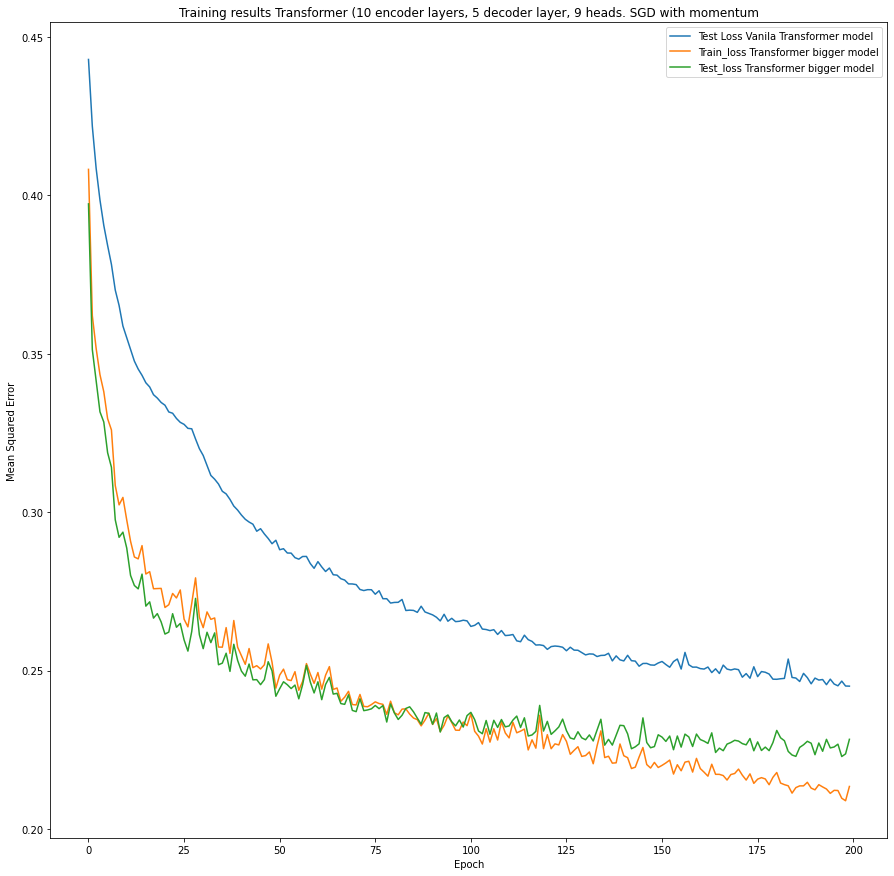

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_5], label= 'Train_loss Transformer bigger model')
  ax.plot([np.mean(i) for i in test_losses_5], label= 'Test_loss Transformer bigger model')
  ax.set_title("Training results Transformer (10 encoder layers, 5 decoder layer, 9 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Training using PCA in the dataset

In [61]:
df =  dataset_norm.copy()

df.pop('time')

df.head()

,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [82]:
# Train using PCA

pca = PCA(n_components=6)
df_pca = pca.fit(df)
df_transformed_pca = df_pca.transform(df)

def create_sequece_dataloaders_pca(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):    
    data = np.array(dataset_norm[i:i+30, :])
    next = np.array(dataset_norm[i+30, :], dtype= float)
    target = np.array(dataset_norm[i+31, :], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

loader_train_seq_pca, loader_test_seq_pca = create_sequece_dataloaders_pca(df_transformed_pca)


def training_transformer_PCA(model, optimizer, criterion, train_loader, test_loader, n_epochs, device, pca):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

100%|██████████| 63300/63300 [00:00<00:00, 199403.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [83]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer_pca = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=6,
                      output_size=6,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_pca.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_pca, train_losses_6, test_losses_6 = training_transformer_PCA(
      model= model_transformer_pca, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_pca, 
      test_loader= loader_test_seq_pca, 
      n_epochs= n_epochs,
      device=device,
      pca=df_pca)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.97it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.55it/s]



Current Mean loss Train Set:  1.005661331289693

Test with test set


100%|██████████| 106/106 [00:00<00:00, 113.50it/s]



Current Mean loss Test Set:  1.0412167766184177


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.82it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.31it/s]



Current Mean loss Train Set:  0.9819152564124057

Test with test set


100%|██████████| 106/106 [00:00<00:00, 114.43it/s]



Current Mean loss Test Set:  1.017743021812079


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 32.18it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.36it/s]



Current Mean loss Train Set:  0.9680814192797008

Test with test set


100%|██████████| 106/106 [00:00<00:00, 115.10it/s]



Current Mean loss Test Set:  1.0035489555799737


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:32<00:00, 29.56it/s]



Test with training set


 85%|████████▌ | 812/950 [00:07<00:01, 113.53it/s]


KeyboardInterrupt: ignored